In [ ]:
# default_exp bulbascraper

# Bulbascraper

> A set of utilities to scrape the Bulbapedia for images of Pokemon Trading Cards.

I needed some images of Pokemon Trading Card Game (TCG) cards to build a training a validation Bulbapedia is an encyclopedia about Pokémon to which anyone can contribute. 

I navigated around Bulbapedia to find images of pokemon cards. I found:
 * a [page on Bulbapedia](https://bulbapedia.bulbagarden.net/wiki/GX_Starter_Decks_(TCG)) that had a list of the characters/cards that are contained in each of the GX Starter Sets. 
 
 * Each item in the list is a link to a specific description page that includes an image of the card itself. It can include a 'gallery' section where more than one version of the artwork exists.
 
 * A page for each character https://bulbapedia.bulbagarden.net/wiki/Heatmor_(TCG) that contains a list of all cards featuring that character/entity. This can give multiple artworks for the same character.

I wanted to extract this list from the page to use as a starting point for collecting images of cards. Developer tools are your friend. Look for something in the html attributes that allows me to pick out these links. I used a combination of `requests` and `BeautifulSoup` to fetch that page provide a list of all the links:

In [ ]:
# export 
BASE_URL = 'https://bulbapedia.bulbagarden.net/wiki/'

In [ ]:
import re
import requests
from bs4 import BeautifulSoup, SoupStrainer

r = requests.get(BASE_URL + 'GX_Starter_Decks_(TCG)')
links = BeautifulSoup(r.content, 'html.parser').find_all('a', {'class':'mw-redirect','href':re.compile('GX_Starter_Deck')})
card_pages = set([l.get('href').split('/')[-1] for l in links])

# expect 131 cards
assert len(card_pages)==131, f'{len(card_pages)} is too many'

We need to visit each of those pages and extract an image. Some of the pages have a gallery section with multiple artworks. Our preference is to gather those up.

The gallery section, if it exists, looks like this:

```<span id="Gallery> ... <span>```

But the table of images that we want is not encapsulated in a `<div>` so we can't use that section heading to get the images embedded as children within it. 

Instead we can extract all `<img>` tags from the page and then filter out unwanted images. Using developer tools we can see that the pokemon/entity name is embedded in the `alt` parameter of the `img` tag for the images we want. The name has any underscore, dash, spaces, punctuation removed so the script has to dea with that. 

Now we can loop through the links to the card pages exracting the urls to the images.

In [ ]:
image_record = {}

for card_page in card_pages:
    r = requests.get(BASE_URL+card_page)
    if r.ok:
        soup = BeautifulSoup(r.content,'html.parser')
        
        n=card_page.split('(')[0][:-1] 
        for char in '_-.:':
            n=n.replace(char,'')
        n = urllib.parse.unquote(n)
    
        gallery_images = soup.findAll('img',{'alt':re.compile(n)})
    
        if len(gallery_images) > 0:
            all_img_urls = set([i.get('src') for i in gallery_images])
            image_record.update({card_page:all_img_urls})
        else:
            print(f'No images for {card_page} : {get_compressed_name(card_page)}')
    else:
        print(f"Error fetching page: {BASE_URL+card_page}")


No images for Devoured_Field_(GX_Starter_Deck_128) : DevouredField


There were no images for 'Devoured Field'. Switching to DevTools once again I can see that this is because the image for this enitity is named DecayingWasteland rather than DevouredField. I'll add an exception for this special case.

I'll refactor the code a little so we can export it as a helper function to the library.

In [ ]:
# export 
import urllib 

IMG_EXCEPTIONS = {'Devoured_Field_(GX_Starter_Deck_128)':'Decaying_Wasteland_()'}
              
def get_camel_name(l): 
    n=IMG_EXCEPTIONS.get(l,l).split('(')[0][:-1]
    for char in '_-.:':
        n=n.replace(char,'')
    
    n = urllib.parse.unquote(n)
    return n

def get_image_from_page(card_name):
    img_urls=[]
    r = requests.get(BASE_URL+card_name)
    if r.ok:
        soup = BeautifulSoup(r.content,'html.parser')
        gallery_images = soup.findAll('img',{'alt':re.compile(get_camel_name(card_name))})
        img_urls = set([i.get('src') for i in gallery_images])
    else:
        print(f"Error fetching page: {BASE_URL+card_page}")
    return {card_name:img_urls}
                  

And now call that from a loop.

In [ ]:
image_record = {}
for card_page in card_pages: 
    image_record.update(get_image_from_page(card_page))    

So what do we have in the image record?

In [ ]:
import altair as alt
import pandas as pd

d=pd.DataFrame([{'name':get_camel_name(k),'N':len(image_record[k])} for k in image_record.keys()])
alt.Chart(d).mark_bar().encode(x='N', y=alt.Y('name',sort='-x')).properties(
    width=300,
    height=1000
)

alt.Chart(...)

So for all cards we have at least one image and for some we have more. Up to 14 for the 'Switch' card. 

Let's have a look at these variations by stepping through each url for the 'Switch' cards, fetching that image and displaying.

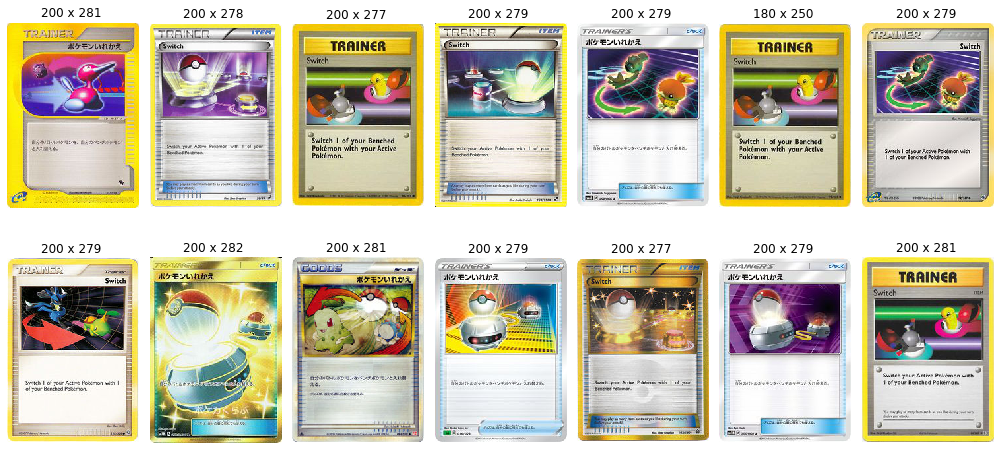

In [ ]:
import matplotlib.pyplot as plt

f,ax = plt.subplots(2,7, figsize=(14,7))

for i,image_url in enumerate(image_record['Switch_(GX_Starter_Deck_113)']):
    r = requests.get(f'http:{image_url}')
    img = plt.imread(BytesIO(r.content),0)
    a=ax[i//7,i%7]
    a.imshow(img)
    a.set_title(f'{img.shape[1]} x {img.shape[0]}')
    a.axis('off')

plt.tight_layout()

There seems a lot of variation in the appearance of these cards. A pokeball seems common to many versions but also there are examples with pokemon and arrows. I'm not sure how this would affect a NN classifier. For now let's leave them in the training set and see what performance we get.

There are some small variations in sizes of the images. Will probably resize them to get some consistency.

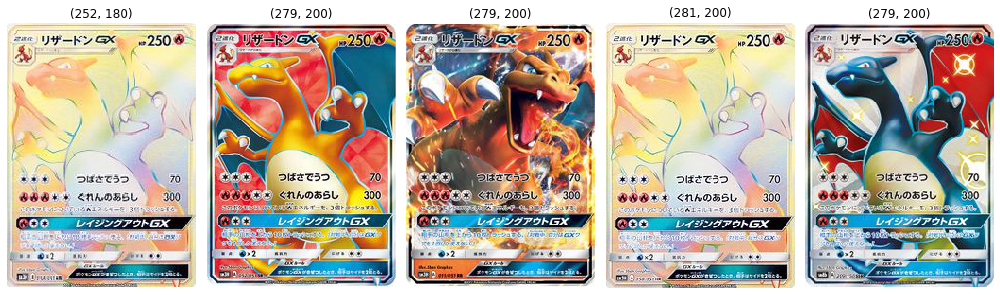

In [ ]:
f,ax = plt.subplots(1,5, figsize=(14,7))

for i,image_url in enumerate(image_record['Charizard-GX_(GX_Starter_Deck_13)']):
    r = requests.get(f'http:{image_url}')
    img = plt.imread(BytesIO(r.content),0)
    a=ax[i]
    a.imshow(img)
    a.set_title(img.shape[0:2])
    a.axis('off')

plt.tight_layout()

The Charizard cards all have something recognizable to the eye as the Charizard character, but there is a variation in pose and coloring. Again it will be interesting to see if the NN can learn what is common between these images.

## Augmenting the images

So we have a set of labelled images of Pokemon Cards that can form a training set. For some, like the Charizard above we have difference in pose and colouring which seems analogous to dog breeds data set. But for most characters we only have one example.

The practical problem in terms of training a neural net here is how do we split this set into training and validation if we had only one example of a given class?

This highlights that ways in which this problem is different to the dog breeds set. In one sense we will only be collecting images of actual pokemon cards that should - in terms of depicted content - match exactly one of the downloaded images. 

But you would expect variation in between images captured of a card e.g. on a phone. For example, difference in lighting condidtions, orientations of the card, background. 

So set about augmenting the original images to account for likely variations in taking images of cards. Produce enough of these variations to provide a training and validation set: So make 50 slightly different images of each pokemon card, with different lighting, skew, rotation, clipping as if they were images of pokemon cards captured in the wild. Then should have enough to split into training and validation sets and proceed.

This is a common situation in training self driving cars. Which is where I borrowed the code from.



In [ ]:
#export

import cv2

def augment_brightness_camera_images(image,brightness):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    # I modified this to suit my needs
    random_bright = brightness+np.random.uniform(low=0.0, high=1-brightness)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range,brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    
    # zoom
    height, width, channels = img.shape

    #prepare the crop
    scale=np.random.uniform(low=0.7, high=1.3)
    
    centerX,centerY=int(height/2),int(width/2)
    radiusX,radiusY= int(np.round(scale*height/2)),int(np.round(scale*width/2))

    minX,maxX=centerX-radiusX,centerX+radiusX
    minY,maxY=centerY-radiusY,centerY+radiusY

    if scale > 1:
        # zoom out
        new_image = np.zeros(((maxX-minX)+1, (maxY-minY)+1,3),dtype=np.uint8)
        x0=-1*minX; y0=-1*minY
        new_image[y0:y0+height,x0:x0+width,:]=img
        img=new_image.copy()
        
    else:
        cropped = img[minX:maxX, minY:maxY]
        resized_cropped = cv2.resize(cropped, (width, height)) 
        img=resized_cropped
    
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness


    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    if brightness != 0:
      img = augment_brightness_camera_images(img,brightness)

    return img

Let's pick a card where we only have one version and augment it to synthetically create something that looks like a set of images of a card that might be captured on a phone.

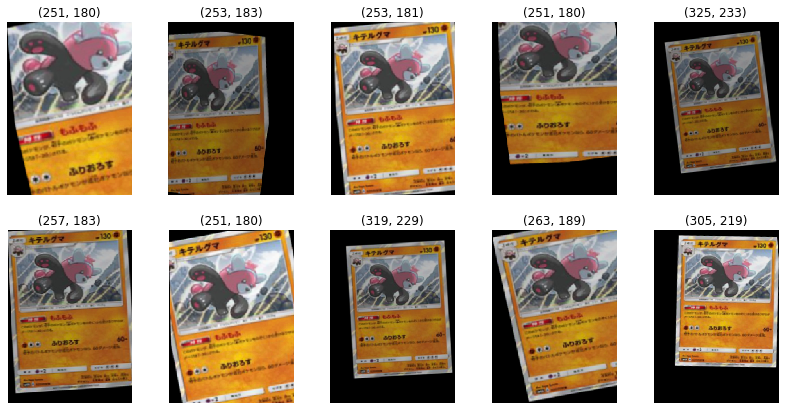

In [ ]:
import numpy as np

N_AUGMENTED_IMAGES = 10

f,ax = plt.subplots(2,5, figsize=(14,7))

src_img_url = list(image_record.get('Bewear_(GX_Starter_Deck_63)'))[0]
r = requests.get(f'http:{src_img_url}')
src_img = plt.imread(BytesIO(r.content),0)

for i in range(N_AUGMENTED_IMAGES):
    img = transform_image(src_img,20,5,10,brightness=0.50)
    a=ax[i//5,i%5]
    a.imshow(img)
    a.set_title(img.shape[0:2])
    a.axis('off')


That black background doesn't look so ~hot~ realistic. Perhaps I can graft in some backgrounds onto the black spaces.

I manually found a few images that could represent tables, parts of rooms etc and saved them to GDrive and made them publicly accesible. Let's fetch them here and then write a bit of code to graft them onto the example images.

In [ ]:
# export 
BKG_SRC = 'https://pokedexproject.s3.eu-west-2.amazonaws.com/background_images/'

def fetch_background_images(src=BKG_SRC, n_images=15):
    
    background_images=[]
    
    for i in range(1, n_images+1):
        r=requests.get(src+f'back{i}.jpg')
        d=plt.imread(BytesIO(r.content),0)
        background_images.append(d)

    return background_images


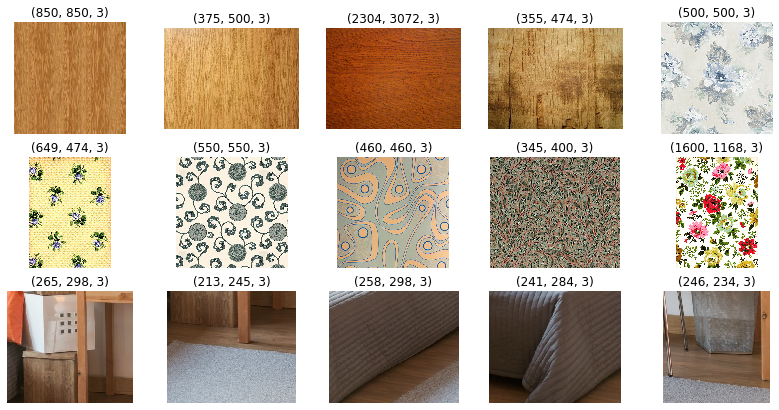

In [ ]:
fetch_background_images()

f,ax = plt.subplots(3,5,figsize=(14,7))
for i,bkgimg in enumerate(background_images):
    a=ax[i//5,i%5]
    a.imshow(bkgimg)
    a.set_title(bkgimg.shape)
    a.axis('off')

In [ ]:
# export 
def apply_random_background(img,background_images):
    """
    simple image compositor
    select random background image from the set provided
    img : target image (numpy array)
    background_images: list of images (numpy array) as backgrounds
    """
    img1 = img.copy()
    N = len(background_images)
    i = int(np.clip(np.round((N-1)*np.random.uniform()),0,N-1))
    img2=np.array(Image.fromarray(background_images[i]).resize(Image.fromarray(img).size))
    
    # create mask for empty areas of target image
    idx=(img<5)
    
    # copy background into those empty areas
    print(img2.shape,img.shape)
    img1[idx]=img2[idx]
    
    return img1


And this is how it would be applied to an image.

(305, 219, 3) (305, 219, 3)


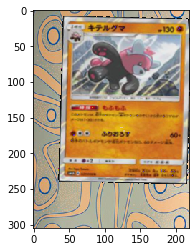

In [ ]:
_ = plt.imshow(apply_random_background(img,background_images))

So now we can augment the original card images by 

Would seem to make sense to wrap this fetching code up into a component that can fetch them all and then save them somewhere. Have done this here, works through the `image_record`, fetches images, and saves them to an AWS S3 bucket.

You will have to have your own credentials to get boto3/AWS to work.

That would be invoked like this:


    push_images_to_s3(card_pages, image_record)

In [ ]:
# export 

import boto3
import sys

def wr(s): 
    sys.stdout.write(s)
    sys.stdout.flush() 
    return None

def push_images_to_s3(card_pages, image_record):
    s3 = boto3.resource('s3')
    for i, card in enumerate(card_pages):
        wr(f'\r{i+1}/{len(card_pages)}: {card}                       ')
        for j, img_url in enumerate(image_record[card]):
            r = requests.get(f'https:{img_url}')
            if r.ok:
                data = BytesIO(r.content)
                fname = img_url.split('/')[-1]
                ret = s3.Bucket('pokedexproject').put_object(Key=f'card_originals/{fname}', Body=data)
                if not ret:
                    print(f"Failed to upload {fname} to S3")